# Bike Lane: Analyzing Big Data from NYC Citibike Rentals

In [118]:
from google.cloud import bigquery
import pandas as pd

In [2]:
import pydata_google_auth
credentials = pydata_google_auth.get_user_credentials(
    ['https://www.googleapis.com/auth/bigquery'],
)

### The Citibike dataset includes 16 features across 59 million customer records from 2013 - 2018. Consequently, in order to mine meaningful data, we'll have to significantly partition and subset this dataset. 

In [115]:
citi_bike_initial_query = """SELECT * FROM `bigquery-public-data.new_york_citibike.citibike_trips`
LIMIT 15""" 
project_id = 'fast-nexus-318411'

In [116]:
client = bigquery.Client(project=project_id, credentials=credentials)
df = client.query(citi_bike_initial_query).to_dataframe()
df

,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,customer_plan
0,432,2013-09-16 19:22:43.000,2013-09-16 19:29:55.000,509,9 Ave & W 22 St,40.745497,-74.001971,442,W 27 St & 7 Ave,40.746647,-73.993915,18447,Subscriber,1951,male,
1,1186,2015-12-30 13:02:38.000,2015-12-30 13:22:25.000,280,E 10 St & 5 Ave,40.733320,-73.995101,254,W 11 St & 6 Ave,40.735324,-73.998004,22598,Subscriber,1945,female,
2,799,2017-09-02 16:27:37.000,2017-09-02 16:40:57.000,335,Washington Pl & Broadway,40.729039,-73.994046,540,Lexington Ave & E 29 St,40.743116,-73.982154,28833,Subscriber,1997,male,
3,238,2017-11-15 06:57:09.000,2017-11-15 07:01:08.000,146,Hudson St & Reade St,40.716250,-74.009106,387,Centre St & Chambers St,40.712733,-74.004607,21338,Subscriber,1998,female,
4,668,2013-11-07 15:12:07.000,2013-11-07 15:23:15.000,529,W 42 St & 8 Ave,40.757570,-73.990985,352,W 56 St & 6 Ave,40.763406,-73.977225,19888,Subscriber,1949,male,
5,593,2013-08-25 13:47:24.000,2013-08-25 13:57:17.000,470,W 20 St & 8 Ave,40.743453,-74.000040,252,MacDougal St & Washington Sq,40.732264,-73.998522,17859,Subscriber,1939,male,
6,414,2018-05-29 16:33:26.488,2018-05-29 16:40:21.206,3158,W 63 St & Broadway,40.771639,-73.982614,3167,Amsterdam Ave & W 73 St,40.779668,-73.980930,19198,Subscriber,1952,male,
7,1643,2014-02-07 20:24:02.000,2014-02-07 20:51:25.000,519,Pershing Square N,40.751884,-73.977702,147,Greenwich St & Warren St,40.715422,-74.011220,18718,Subscriber,1947,male,
8,474,2017-10-06 12:17:06.000,2017-10-06 12:25:00.000,470,W 20 St & 8 Ave,40.743453,-74.000040,496,E 16 St & 5 Ave,40.737262,-73.992390,14823,Subscriber,1996,male,
9,2277,2014-09-11 05:46:58.000,2014-09-11 06:24:55.000,487,E 20 St & FDR Drive,40.733143,-73.975739,487,E 20 St & FDR Drive,40.733143,-73.975739,18116,Subscriber,1946,male,


### This project will seek to provide insights relating to the following questions:

#### What is the average trip length for Citibike users? 
#### What was the average number of daily trips for years 2013 - 2018?
#### What was the cumulative trip count for 2013 to 2018?
#### What was the average age for subscribers? Customers?
#### Which year saw the most daily trips? Most cumulative trips?
#### How did trip duration differ between the two user types, subscriber and customer? 
#### Did users rent from east or west side stations more often? Which were the most popular stations?

In [130]:
df['tripduration'].mean()/60

13.85

### The average trip length was approximately 14 minutes. 

In [41]:
num_trips_2013 = """ WITH trips_by_day AS
                     (
                     SELECT DATE(starttime) AS trip_date,
                         COUNT(*) AS num_trips
                     FROM `bigquery-public-data.new_york_citibike.citibike_trips`
                     WHERE EXTRACT(YEAR FROM starttime) = 2013
                     GROUP BY trip_date
                     )
                     SELECT *, 
                     SUM(num_trips)
                     OVER
                     ( 
                     ORDER BY trip_date
                     ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
                     ) AS cumulative_trips
                     FROM trips_by_day
"""

In [42]:
client = bigquery.Client(project=project_id, credentials=credentials)
num_trips_df = client.query(num_trips_2013).to_dataframe()
num_trips_df

,trip_date,num_trips,cumulative_trips
0,2013-07-01,16650,16650
1,2013-07-02,22745,39395
2,2013-07-03,21864,61259
3,2013-07-04,22326,83585
4,2013-07-05,21842,105427
...,...,...,...
179,2013-12-27,11720,4997723
180,2013-12-28,12022,5009745
181,2013-12-29,3775,5013520
182,2013-12-30,13241,5026761


In [463]:
print('The average number of daily trips in 2013 was:', round(num_trips_df['num_trips'].mean()))
print('The average number of daily trips in 2014 was:', round(num_trips_2014_df['num_trips'].mean()))
print('The average number of daily trips in 2015 was:', round(num_trips_2015_df['num_trips'].mean()))
print('The average number of daily trips in 2016 was:', round(num_trips_2016_df['num_trips'].mean()))
print('The average number of daily trips in 2017 was:', round(num_trips_2017_df['num_trips'].mean()))
print('The average number of daily trips in 2018 was:', round(num_trips_2018_df['num_trips'].mean()))

The average number of daily trips in 2013 was: 27376
The average number of daily trips in 2014 was: 22140
The average number of daily trips in 2015 was: 27227
The average number of daily trips in 2016 was: 38010
The average number of daily trips in 2017 was: 51341
The average number of daily trips in 2018 was 37557


### In 2013, New York Citibike users took over 5 million cumulative trips. On average, users rented over 27,000 bikes per day. In 2018 Citibike users were renting over 10,000 more bikes per day than in 2013. However, daily rentals peaked in 2017 with over 50,000 per day. 

In [466]:
print('The number of cumulative trips for 2013 was:', round(num_trips_df['cumulative_trips'].max()))
print('The number of cumulative trips for 2014 was:', round(num_trips_2014_df['cumulative_trips'].max()))
print('The number of cumulative trips for 2015 was:', round(num_trips_2015_df['cumulative_trips'].max()))
print('The number of cumulative trips for 2016 was:', round(num_trips_2016_df['cumulative_trips'].max()))
print('The number of cumulative trips for 2017 was:', round(num_trips_2017_df['cumulative_trips'].max()))
print('The number of cumulative trips for 2018 was:', round(num_trips_2018_df['cumulative_trips'].max()))

The number of cumulative trips for 2013 was: 5037185
The number of cumulative trips for 2014 was: 8081216
The number of cumulative trips for 2015 was: 9937969
The number of cumulative trips for 2016 was: 10262649
The number of cumulative trips for 2017 was: 14118669
The number of cumulative trips for 2018 was: 5671033


### Users took the most trips in 2017, renting over 14 million times by the end of the year.

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

(array([15887., 15918., 15949., 15979., 16010., 16040., 16071.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

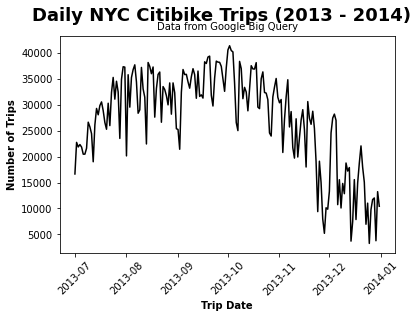

In [556]:
plt.suptitle('Daily NYC Citibike Trips (2013 - 2014)', weight = 'bold', color = 'black').set_fontsize(18)
plt.title('Data from Google Big Query', color = 'black').set_fontsize(10)
sns.lineplot(x = 'trip_date', y = 'num_trips', data = num_trips_df, color = 'black')
plt.xlabel('Trip Date', weight = 'bold', color = 'black')
plt.ylabel('Number of Trips', weight = 'bold', color = 'black')
plt.xticks(rotation=45)

In [63]:
num_trips_2014_df = """ WITH trips_by_day AS
                     (
                     SELECT DATE(starttime) AS trip_date,
                         COUNT(*) AS num_trips
                     FROM `bigquery-public-data.new_york_citibike.citibike_trips`
                     WHERE EXTRACT(YEAR FROM starttime) = 2014
                     GROUP BY trip_date
                     )
                     SELECT *,
                     SUM(num_trips)
                     OVER
                     (
                     ORDER BY trip_date 
                     ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
                     ) AS cumulative_trips
                     FROM trips_by_day

"""

In [64]:
client = bigquery.Client(project = project_id, credentials = credentials)
num_trips_2014_df = client.query(num_trips_2014_df).to_dataframe()
num_trips_2014_df

,trip_date,num_trips,cumulative_trips
0,2014-01-01,6059,6059
1,2014-01-02,8600,14659
2,2014-01-03,1144,15803
3,2014-01-04,2292,18095
4,2014-01-05,2678,20773
...,...,...,...
360,2014-12-27,10247,8037830
361,2014-12-28,7902,8045732
362,2014-12-29,13549,8059281
363,2014-12-30,12196,8071477


In [241]:
client = bigquery.Client(project = project_id, credentials = credentials)
cumu_trips_2014_df = client.query(cumu_trips_2014).to_dataframe()
cumu_trips_2014_df

,trip_date,num_trips,cumulative_trips
0,2014-01-01,6059,6059
1,2014-01-02,8600,14659
2,2014-01-03,1144,15803
3,2014-01-04,2292,18095
4,2014-01-05,2678,20773
...,...,...,...
360,2014-12-27,10247,8037830
361,2014-12-28,7902,8045732
362,2014-12-29,13549,8059281
363,2014-12-30,12196,8071477


In [117]:
num_trips_2014_df.describe()

,num_trips,cumulative_trips
count,365.000000,3.650000e+02
mean,22140.317808,3.725638e+06
std,10314.842592,2.723274e+06
min,876.000000,6.059000e+03
25%,13119.000000,1.010676e+06
50%,23822.000000,3.499466e+06
75%,31330.000000,6.352190e+06
max,38619.000000,8.081216e+06


(array([15887., 15979., 16071., 16161., 16252., 16344., 16436., 16526.,
        16617., 16709., 16801.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

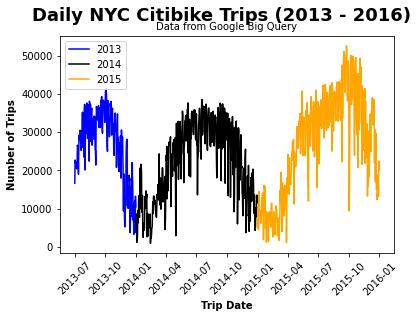

In [557]:
plt.suptitle('Daily NYC Citibike Trips (2013 - 2016)', weight = 'bold', color = 'black').set_fontsize(18)
plt.title('Data from Google Big Query', color = 'black').set_fontsize(10)
sns.lineplot(x = 'trip_date', y = 'num_trips', data = num_trips_df, color = 'blue', label = '2013')
sns.lineplot(x = 'trip_date', y = 'num_trips', data = num_trips_2014_df, color = 'black', label = '2014')
sns.lineplot(x = 'trip_date', y = 'num_trips', data = num_trips_2015_df, color = 'orange', label = '2015')
plt.xlabel('Trip Date', weight = 'bold', color = 'black')
plt.ylabel('Number of Trips', weight = 'bold', color = 'black')
plt.xticks(rotation=45)

(array([16801., 16832., 16861., 16892., 16922., 16953., 16983., 17014.,
        17045., 17075.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

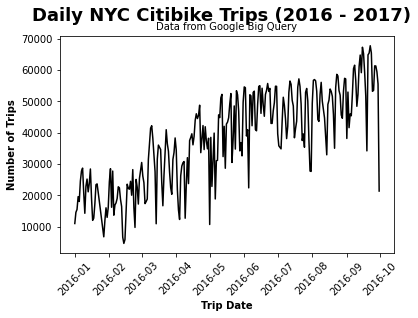

In [558]:
plt.suptitle('Daily NYC Citibike Trips (2016 - 2017)', weight = 'bold', color = 'black').set_fontsize(18)
plt.title('Data from Google Big Query', color = 'black').set_fontsize(10)
sns.lineplot(x = 'trip_date', y = 'num_trips', data = num_trips_2016_df, color = 'black')
plt.xlabel('Trip Date', weight = 'bold', color = 'black')
plt.ylabel('Number of Trips', weight = 'bold', color = 'black')
plt.xticks(rotation=45)

In [78]:
num_trips_2015_df = """ WITH trips_by_day AS
                        (
                        SELECT DATE(starttime) AS trip_date,
                            COUNT(*) AS num_trips,
                        FROM `bigquery-public-data.new_york_citibike.citibike_trips`
                        WHERE EXTRACT(YEAR FROM starttime) = 2015
                        GROUP BY trip_date
                        )
                        SELECT *,
                        SUM(num_trips) 
                        OVER
                        (
                        ORDER BY trip_date
                        ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
                        ) AS cumulative_trips
                        FROM trips_by_day
"""

In [79]:
client = bigquery.Client(project=project_id, credentials=credentials)
num_trips_2015_df = client.query(num_trips_2015_df).to_dataframe()
num_trips_2015_df

,trip_date,num_trips,cumulative_trips
0,2015-01-01,5317,5317
1,2015-01-02,11304,16621
2,2015-01-03,4478,21099
3,2015-01-04,7849,28948
4,2015-01-05,14506,43454
...,...,...,...
360,2015-12-27,13177,9862880
361,2015-12-28,18889,9881769
362,2015-12-29,13347,9895116
363,2015-12-30,22477,9917593


In [88]:
num_trips_2016_df = """ WITH trips_by_day AS
                     (
                     SELECT DATE(starttime) AS trip_date,
                         COUNT(*) AS num_trips
                     FROM `bigquery-public-data.new_york_citibike.citibike_trips`
                     WHERE EXTRACT(YEAR FROM starttime) = 2016
                     GROUP BY trip_date
                     )
                     SELECT *,
                     SUM(num_trips) 
                     OVER
                     (
                     ORDER BY trip_date
                     ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
                     ) AS cumulative_trips
                     FROM trips_by_day
"""

In [89]:
client = bigquery.Client(project=project_id, credentials=credentials)
num_trips_2016_df = client.query(num_trips_2016_df).to_dataframe()
num_trips_2016_df

,trip_date,num_trips,cumulative_trips
0,2016-01-01,11009,11009
1,2016-01-02,14587,25596
2,2016-01-03,15499,41095
3,2016-01-04,19593,60688
4,2016-01-05,18053,78741
...,...,...,...
265,2016-09-26,61386,10064880
266,2016-09-27,61346,10126226
267,2016-09-28,59464,10185690
268,2016-09-29,55578,10241268


In [100]:
num_trips_2017_df = """ WITH trips_by_day AS
                        (
                        SELECT DATE(starttime) AS trip_date,
                            COUNT(*) AS num_trips
                        FROM `bigquery-public-data.new_york_citibike.citibike_trips`
                        WHERE EXTRACT(YEAR FROM starttime) = 2017
                        GROUP BY trip_date
                        )
                        SELECT *, 
                        SUM(num_trips)
                        OVER
                        (
                        ORDER BY trip_date
                        ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
                        ) AS cumulative_trips
                        FROM trips_by_day
"""

In [101]:
client = bigquery.Client(project=project_id, credentials=credentials)
num_trips_2017_df = client.query(num_trips_2017_df).to_dataframe()
num_trips_2017_df

,trip_date,num_trips,cumulative_trips
0,2017-04-01,23849,23849
1,2017-04-02,39780,63629
2,2017-04-03,43485,107114
3,2017-04-04,29991,137105
4,2017-04-05,47636,184741
...,...,...,...
270,2017-12-27,16365,14078965
271,2017-12-28,13420,14092385
272,2017-12-29,13759,14106144
273,2017-12-30,5956,14112100


(array([16436., 16495., 16556., 16617., 16679., 16740., 16801.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

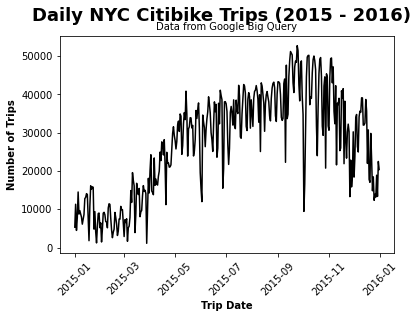

In [559]:
plt.suptitle('Daily NYC Citibike Trips (2015 - 2016)', weight = 'bold', color = 'black').set_fontsize(18)
plt.title('Data from Google Big Query', color = 'black').set_fontsize(10)
sns.lineplot(x = 'trip_date', y = 'num_trips', data = num_trips_2015_df, color = 'black')
plt.xlabel('Trip Date', weight = 'bold', color = 'black')
plt.ylabel('Number of Trips', weight = 'bold', color = 'black')
plt.xticks(rotation=45)

(array([17257., 17287., 17318., 17348., 17379., 17410., 17440., 17471.,
        17501., 17532.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

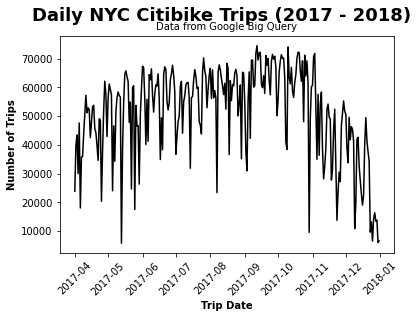

In [560]:
plt.suptitle('Daily NYC Citibike Trips (2017 - 2018)', weight = 'bold', color = 'black').set_fontsize(18)
plt.title('Data from Google Big Query', color = 'black').set_fontsize(10)
sns.lineplot(x = 'trip_date', y = 'num_trips', data = num_trips_2017_df, color = 'black')
plt.xlabel('Trip Date', weight = 'bold', color = 'black')
plt.ylabel('Number of Trips', weight = 'bold', color = 'black')
plt.xticks(rotation=45)

(array([17287., 17348., 17410., 17471., 17532., 17591., 17652.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

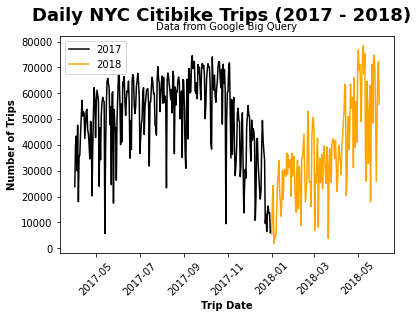

In [561]:
plt.suptitle('Daily NYC Citibike Trips (2017 - 2018)', weight = 'bold', color = 'black').set_fontsize(18)
plt.title('Data from Google Big Query', color = 'black').set_fontsize(10)
sns.lineplot(x = 'trip_date', y = 'num_trips', data = num_trips_2017_df, color = 'black', label = '2017')
sns.lineplot(x = 'trip_date', y = 'num_trips', data = num_trips_2018_df, color = 'orange', label = '2018')
plt.xlabel('Trip Date', weight = 'bold', color = 'black')
plt.ylabel('Number of Trips', weight = 'bold', color = 'black')
plt.xticks(rotation=45)

In [109]:
num_trips_2018_query = """ WITH trips_by_day AS
                        (
                        SELECT DATE(starttime) AS trip_date,
                        COUNT(*) AS num_trips
                        FROM `bigquery-public-data.new_york_citibike.citibike_trips`
                        WHERE EXTRACT(YEAR FROM starttime) = 2018
                        GROUP BY trip_date
                        )
                        SELECT *, 
                        SUM(num_trips) 
                        OVER
                        (
                        ORDER BY trip_date
                        ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
                        ) AS cumulative_trips
                        FROM trips_by_day
"""

In [110]:
client = bigquery.Client(project = project_id, credentials=credentials)
num_trips_2018_df = client.query(num_trips_2018_query).to_dataframe()
num_trips_2018_df

,trip_date,num_trips,cumulative_trips
0,2018-01-01,5500,5500
1,2018-01-02,18818,24318
2,2018-01-03,24299,48617
3,2018-01-04,1922,50539
4,2018-01-05,4972,55511
...,...,...,...
146,2018-05-27,25814,5424785
147,2018-05-28,49043,5473828
148,2018-05-29,69090,5542918
149,2018-05-30,72321,5615239


(array([17532., 17563., 17591., 17622., 17652., 17683.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

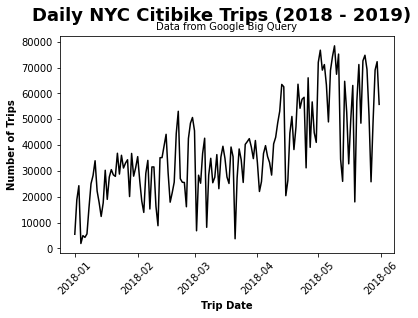

In [562]:
plt.suptitle('Daily NYC Citibike Trips (2018 - 2019)', weight = 'bold', color = 'black').set_fontsize(18)
plt.title('Data from Google Big Query', color = 'black').set_fontsize(10)
sns.lineplot(x = 'trip_date', y = 'num_trips', data = num_trips_2018_df, color = 'black')
plt.xlabel('Trip Date', weight = 'bold', color = 'black')
plt.ylabel('Number of Trips', weight = 'bold', color = 'black')
plt.xticks(rotation=45)

In [179]:
sub_trips =    """ SELECT COUNT(usertype) AS count_subscribers, AVG(tripduration) / 60 AS avg_trip
                   FROM `bigquery-public-data.new_york_citibike.citibike_trips`
                   WHERE usertype = 'Subscriber'
                   ORDER BY count_subscribers DESC 
                     """ 

In [180]:
client = bigquery.Client(project=project_id, credentials=credentials)
sub_trips_df = client.query(sub_trips).to_dataframe()
sub_trips_df

,count_subscribers,avg_trip
0,46917572,13.439698


### Of the clients included in the database for 2013 - 2018, over 46 million users are Citibike subscribers, meaning that nearly 80 percent of users are Citibike subscribers. 

In [181]:
cust_trips =    """ SELECT COUNT(usertype) AS count_customers, AVG(tripduration) / 60 AS avg_trip
                   FROM `bigquery-public-data.new_york_citibike.citibike_trips`
                   WHERE usertype = 'Customer'
                   ORDER BY count_customers DESC 
                     """ 

In [182]:
client = bigquery.Client(project=project_id, credentials=credentials)
cust_trips_df = client.query(cust_trips).to_dataframe()
cust_trips_df

,count_customers,avg_trip
0,6191149,35.758535


### Conversely, 6 million users are simply customers, paying per trip. However, notably, the customers' average trip was double that of the subscribers' trips at 36 minutes to 13 minutes, respectively. 

In [205]:
cust_trip_2014 = """ WITH trips_by_day AS
                     (
                     SELECT DATE(starttime) AS trip_date,
                         COUNT(*) AS num_trips
                     FROM `bigquery-public-data.new_york_citibike.citibike_trips`
                     WHERE EXTRACT(YEAR FROM starttime) = 2014 AND usertype = 'Customer'
                     GROUP BY trip_date
                     )
                     SELECT *,
                     SUM(num_trips)
                     OVER
                     (
                     ORDER BY trip_date 
                     ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
                     ) AS cumulative_trips
                     FROM trips_by_day """

In [206]:
client = bigquery.Client(project=project_id, credentials=credentials)
cust_trips_2014_df = client.query(cust_trip_2014).to_dataframe()
cust_trips_2014_df

,trip_date,num_trips,cumulative_trips
0,2014-01-01,652,652
1,2014-01-02,181,833
2,2014-01-03,21,854
3,2014-01-04,29,883
4,2014-01-05,35,918
...,...,...,...
360,2014-12-27,2007,790168
361,2014-12-28,962,791130
362,2014-12-29,1140,792270
363,2014-12-30,639,792909


In [207]:
sub_trip_2014 = """ WITH trips_by_day AS
                    (
                    SELECT DATE(starttime) AS trip_date, 
                        COUNT(*) AS num_trips
                    FROM `bigquery-public-data.new_york_citibike.citibike_trips`
                    WHERE EXTRACT(YEAR FROM starttime) = 2014 AND usertype = 'Subscriber'
                    GROUP BY trip_date
                    )
                    SELECT *, SUM(num_trips)
                    OVER
                    (
                    ORDER BY num_trips DESC
                    ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW 
                    ) AS cumulative_trips
                    FROM trips_by_day
"""

In [208]:
client = bigquery.Client(project=project_id, credentials=credentials)
sub_trips_2014_df = client.query(sub_trip_2014).to_dataframe()
sub_trips_2014_df

,trip_date,num_trips,cumulative_trips
0,2014-07-17,35377,35377
1,2014-09-10,34818,70195
2,2014-09-17,34690,104885
3,2014-09-18,34682,139567
4,2014-09-11,34439,174006
...,...,...,...
360,2014-01-22,2423,7281249
361,2014-01-04,2263,7283512
362,2014-02-15,2213,7285725
363,2014-01-03,1123,7286848


In [218]:
sub_trip_2014_daily_count = """
                    SELECT DATE(starttime) AS trip_date, 
                        COUNT(*) AS num_trips
                    FROM `bigquery-public-data.new_york_citibike.citibike_trips`
                    WHERE EXTRACT(YEAR FROM starttime) = 2014 AND usertype = 'Subscriber'
                    GROUP BY trip_date
                    
"""

In [219]:
client = bigquery.Client(project=project_id, credentials=credentials)
sub_trips_2014_daily_count_df = client.query(sub_trip_2014_daily_count).to_dataframe()
sub_trips_2014_daily_count_df

,trip_date,num_trips
0,2014-02-07,8427
1,2014-09-11,34439
2,2014-11-03,25243
3,2014-09-09,32359
4,2014-12-05,15469
...,...,...
360,2014-02-13,873
361,2014-02-06,7123
362,2014-02-05,2720
363,2014-01-03,1123


(array([-5000.,     0.,  5000., 10000., 15000., 20000., 25000., 30000.,
        35000., 40000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

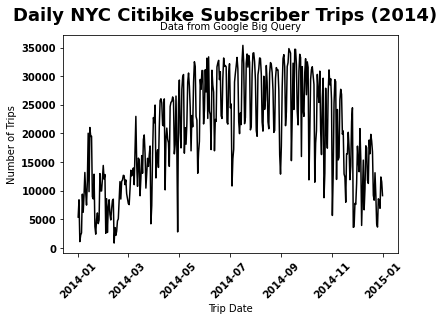

In [222]:
plt.suptitle('Daily NYC Citibike Subscriber Trips (2014)', weight = 'bold', color = 'black').set_fontsize(18)
plt.title('Data from Google Big Query', color = 'black').set_fontsize(10)
sns.lineplot(x = 'trip_date', y = 'num_trips', data = sub_trips_2014_daily_count_df, color = 'black')
plt.xlabel('Trip Date')
plt.ylabel('Number of Trips')
plt.xticks(rotation=45, weight = 'bold', color = 'black')
plt.yticks(weight = 'bold', color = 'black')

In [223]:
cust_trip_2014 = """ 
                     SELECT DATE(starttime) AS trip_date,
                         COUNT(*) AS num_trips
                     FROM `bigquery-public-data.new_york_citibike.citibike_trips`
                     WHERE EXTRACT(YEAR FROM starttime) = 2014 AND usertype = 'Customer'
                     GROUP BY trip_date
                      """

In [224]:
client = bigquery.Client(project=project_id, credentials=credentials)
cust_trip_2014_df = client.query(cust_trip_2014).to_dataframe()
cust_trip_2014_df

,trip_date,num_trips
0,2014-05-03,5354
1,2014-08-31,5143
2,2014-06-07,7321
3,2014-08-07,3263
4,2014-01-12,776
...,...,...
360,2014-01-05,35
361,2014-12-09,38
362,2014-01-03,21
363,2014-01-29,55


(array([-5000.,     0.,  5000., 10000., 15000., 20000., 25000., 30000.,
        35000., 40000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

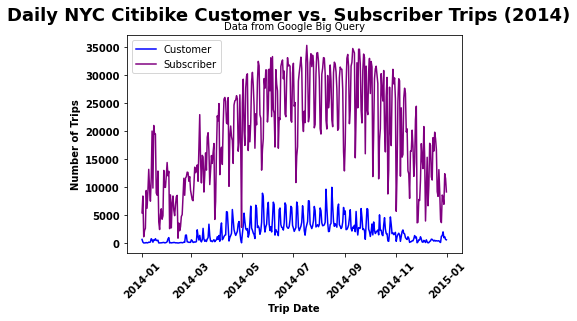

In [236]:
plt.suptitle('Daily NYC Citibike Customer vs. Subscriber Trips (2014)', weight = 'bold', color = 'black').set_fontsize(18)
plt.title('Data from Google Big Query', color = 'black').set_fontsize(10)
sns.lineplot(x = 'trip_date', y = 'num_trips', data = cust_trip_2014_df, color = 'blue', label = 'Customer')
sns.lineplot(x = 'trip_date', y = 'num_trips', data = sub_trips_2014_daily_count_df, color = 'purple', label = 'Subscriber')
plt.xlabel('Trip Date', weight = 'bold', color = 'black')
plt.ylabel('Number of Trips', weight = 'bold', color = 'black')
plt.xticks(rotation=45, weight = 'bold', color = 'black')
plt.yticks(weight = 'bold', color = 'black')

In [244]:
sub_trip_2015_daily_count = """
                    SELECT DATE(starttime) AS trip_date, 
                        COUNT(*) AS num_trips
                    FROM `bigquery-public-data.new_york_citibike.citibike_trips`
                    WHERE EXTRACT(YEAR FROM starttime) = 2015 AND usertype = 'Subscriber'
                    GROUP BY trip_date
                    
"""

In [246]:
client = bigquery.Client(project=project_id, credentials=credentials)
sub_trip_2015_df = client.query(sub_trip_2015_daily_count).to_dataframe()
sub_trip_2015_df

,trip_date,num_trips
0,2015-11-01,24484
1,2015-12-05,22463
2,2015-04-16,25436
3,2015-09-08,37914
4,2015-03-08,7450
...,...,...
360,2015-02-09,5110
361,2015-01-31,5118
362,2015-03-28,1096
363,2015-01-27,1185


In [247]:
cust_trip_2015_daily_count = """
                    SELECT DATE(starttime) AS trip_date, 
                        COUNT(*) AS num_trips
                    FROM `bigquery-public-data.new_york_citibike.citibike_trips`
                    WHERE EXTRACT(YEAR FROM starttime) = 2015 AND usertype = 'Customer'
                    GROUP BY trip_date
                    
"""

In [248]:
client = bigquery.Client(project=project_id, credentials=credentials)
cust_trip_2015_daily_count_df = client.query(cust_trip_2015_daily_count).to_dataframe()
cust_trip_2015_daily_count_df

,trip_date,num_trips
0,2015-06-17,4053
1,2015-07-27,5010
2,2015-12-25,5802
3,2015-10-11,11786
4,2015-07-19,8196
...,...,...
360,2015-02-09,50
361,2015-02-02,10
362,2015-02-19,32
363,2015-03-05,4


(array([-10000.,      0.,  10000.,  20000.,  30000.,  40000.,  50000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

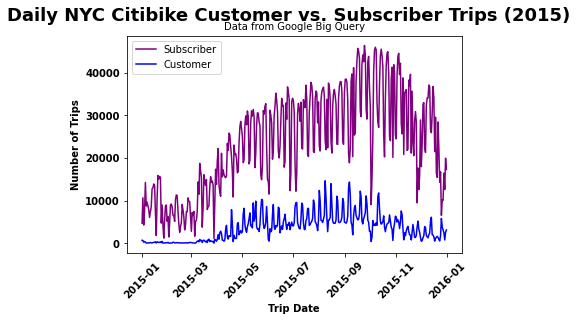

In [249]:
plt.suptitle('Daily NYC Citibike Customer vs. Subscriber Trips (2015)', weight = 'bold', color = 'black').set_fontsize(18)
plt.title('Data from Google Big Query', color = 'black').set_fontsize(10)
sns.lineplot(x = 'trip_date', y = 'num_trips', data = sub_trip_2015_df, color = 'purple', label = 'Subscriber')
sns.lineplot(x = 'trip_date', y = 'num_trips', data = cust_trip_2015_daily_count_df, color = 'blue', label = 'Customer')
plt.xlabel('Trip Date', weight = 'bold', color = 'black')
plt.ylabel('Number of Trips', weight = 'bold', color = 'black')
plt.xticks(rotation=45, weight = 'bold', color = 'black')
plt.yticks(weight = 'bold', color = 'black')

In [291]:
eighteen_thirty_five = """ SELECT DATE(starttime) AS trip_date,
                  tripduration / 60 AS trip_in_min, 2021 - birth_year AS age,
                  FROM `bigquery-public-data.new_york_citibike.citibike_trips`
                  WHERE birth_year BETWEEN 1985 AND 2003 AND usertype = 'Subscriber'
                  ORDER BY birth_year DESC 
"""

In [292]:
client = bigquery.Client(project=project_id, credentials=credentials)
eighteen_thirty_five_df = client.query(eighteen_thirty_five).to_dataframe()
eighteen_thirty_five_df

,trip_date,trip_in_min,age
0,2018-04-11,6.883333,19
1,2018-04-09,3.300000,19
2,2018-04-24,4.683333,19
3,2018-05-14,4.200000,19
4,2018-05-08,4.866667,19
...,...,...,...
15721818,2014-09-20,29.383333,36
15721819,2014-10-01,6.100000,36
15721820,2017-08-22,30.216667,36
15721821,2016-01-27,7.750000,36


### One of the most significant KPIs for any business is how sales perform among the 18 - 35 year-old demographic. Consequently, this project examined the age distribution for both subscribers and customers and found that the majority of customers in the coveted demographic are between the ages of 30 and 35. 

(array([17.5, 20. , 22.5, 25. , 27.5, 30. , 32.5, 35. , 37.5]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

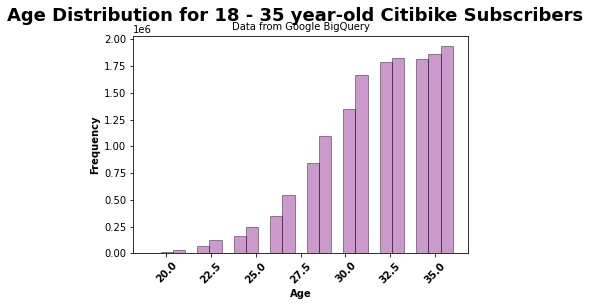

In [313]:
plt.suptitle('Age Distribution for 18 - 35 year-old Citibike Subscribers', weight = 'bold', color = 'black').set_fontsize(18)
plt.title('Data from Google BigQuery', color = 'black').set_fontsize(10)
sns.distplot(eighteen_thirty_five_df['age'], kde=False, bins = 25, color = 'purple', hist_kws=dict(edgecolor='black'))
plt.xlabel('Age', weight = 'bold', color = 'black')
plt.ylabel('Frequency', weight = 'bold', color = 'black')
plt.xticks(rotation=45, weight = 'bold', color = 'black')

In [296]:
all_age = """ SELECT DATE(starttime) AS trip_date,
                  tripduration / 60 AS trip_in_min, 2021 - birth_year AS age,
                  FROM `bigquery-public-data.new_york_citibike.citibike_trips`
                  WHERE usertype = 'Subscriber'
                  ORDER BY birth_year DESC 
"""

In [297]:
client = bigquery.Client(project=project_id, credentials=credentials)
all_age_df = client.query(all_age).to_dataframe()
all_age_df

,trip_date,trip_in_min,age
0,2018-05-31,3.383333,19.0
1,2018-05-24,14.316667,19.0
2,2018-05-14,4.200000,19.0
3,2018-05-02,3.533333,19.0
4,2018-04-27,16.883333,19.0
...,...,...,...
46917567,2017-07-28,5.933333,NaN
46917568,2017-10-30,8.266667,NaN
46917569,2016-06-02,5.216667,NaN
46917570,2016-09-14,2.550000,NaN


(array([  0.,  20.,  40.,  60.,  80., 100., 120., 140., 160.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

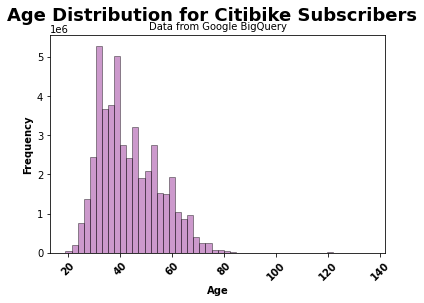

In [311]:
plt.suptitle('Age Distribution for Citibike Subscribers', weight = 'bold', color = 'black').set_fontsize(18)
plt.title('Data from Google BigQuery', color = 'black').set_fontsize(10)
sns.distplot(all_age_df['age'], kde=False, bins = 50, color = 'purple', hist_kws=dict(edgecolor='black'))
plt.xlabel('Age', weight = 'bold', color = 'black')
plt.ylabel('Frequency', weight = 'bold', color = 'black')
plt.xticks(rotation=45, weight = 'bold', color = 'black')

In [520]:
print('The average age for Citibike subscribers is:', round(all_age_df['age'].mean()))

The average age for Citibike subscribers is: 44


### However, when the sample size encompasses subscribers of all ages, the most frequent customers are in their early 40s to early 50s, with a mean age of 44. 

In [513]:
all_age_m = """ SELECT DATE(starttime) AS trip_date,
                  tripduration / 60 AS trip_in_min, 2021 - birth_year AS age,
                  FROM `bigquery-public-data.new_york_citibike.citibike_trips`
                  WHERE usertype = 'Subscriber' AND gender = 'male'
                  ORDER BY birth_year DESC 
"""

In [514]:
client = bigquery.Client(project=project_id, credentials=credentials)
all_age_m_df = client.query(all_age_m).to_dataframe()
all_age_m_df

,trip_date,trip_in_min,age
0,2018-05-27,19.650000,19.0
1,2018-04-16,26.750000,19.0
2,2018-03-18,32.183333,19.0
3,2018-05-14,12.616667,19.0
4,2018-05-03,5.383333,19.0
...,...,...,...
35308518,2014-07-22,10.516667,NaN
35308519,2016-09-21,16.133333,NaN
35308520,2014-10-30,11.466667,NaN
35308521,2017-11-06,22.816667,NaN


(array([  0.,  20.,  40.,  60.,  80., 100., 120., 140., 160.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

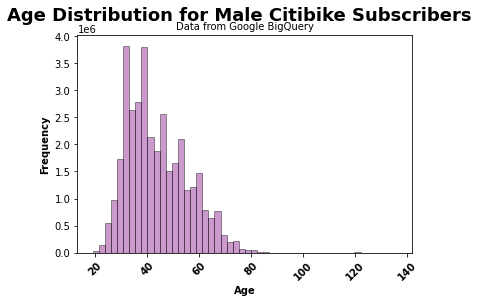

In [521]:
plt.suptitle('Age Distribution for Male Citibike Subscribers', weight = 'bold', color = 'black').set_fontsize(18)
plt.title('Data from Google BigQuery', color = 'black').set_fontsize(10)
sns.distplot(all_age_m_df['age'], kde=False, bins = 50, color = 'purple', hist_kws=dict(edgecolor='black'))
plt.xlabel('Age', weight = 'bold', color = 'black')
plt.ylabel('Frequency', weight = 'bold', color = 'black')
plt.xticks(rotation=45, weight = 'bold', color = 'black')

In [524]:
print('The average age for male Citibike subscribers is:', round(all_age_m_df['age'].mean()))
print('The median age for male Citibike subscribers is:', round(all_age_m_df['age'].median()))

The average age for male Citibike subscribers is: 44
The median age for male Citibike subscribers is: 42


### For male subscribers, the average and median ages are 44 and 42, respectively. 

In [516]:
all_age_f = """ SELECT DATE(starttime) AS trip_date,
                  tripduration / 60 AS trip_in_min, 2021 - birth_year AS age,
                  FROM `bigquery-public-data.new_york_citibike.citibike_trips`
                  WHERE usertype = 'Subscriber' AND gender = 'female'
                  ORDER BY birth_year DESC 
"""

In [517]:
client = bigquery.Client(project=project_id, credentials=credentials)
all_age_f_df = client.query(all_age_f).to_dataframe()
all_age_f_df

,trip_date,trip_in_min,age
0,2018-03-15,6.300000,20.0
1,2017-12-14,7.100000,20.0
2,2017-07-21,3.766667,20.0
3,2017-10-18,1.900000,20.0
4,2017-10-06,38.033333,20.0
...,...,...,...
11188706,2017-11-30,5.666667,NaN
11188707,2017-11-15,6.516667,NaN
11188708,2017-04-07,2.250000,NaN
11188709,2016-06-15,1.483333,NaN


In [526]:
print('The average age for female Citibike subscribers is:', round(all_age_f_df['age'].mean()))
print('The median age for female Citibike subscribers is:', round(all_age_f_df['age'].median()))

The average age for female Citibike subscribers is: 42
The median age for female Citibike subscribers is: 39


### For female subscribers, the ages are slightly lower, but still tend to edge toward middle age. The mean age for a female subscriber is 42 while the median age is 39. 

(array([  0.,  20.,  40.,  60.,  80., 100., 120., 140., 160.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

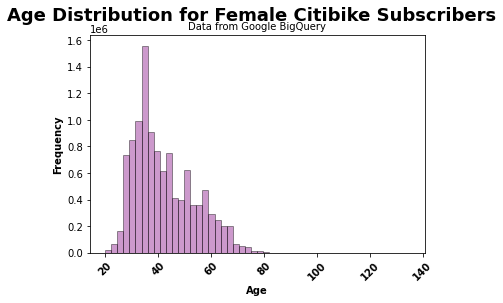

In [519]:
plt.suptitle('Age Distribution for Female Citibike Subscribers', weight = 'bold', color = 'black').set_fontsize(18)
plt.title('Data from Google BigQuery', color = 'black').set_fontsize(10)
sns.distplot(all_age_f_df['age'], kde=False, bins = 50, color = 'purple', hist_kws=dict(edgecolor='black'))
plt.xlabel('Age', weight = 'bold', color = 'black')
plt.ylabel('Frequency', weight = 'bold', color = 'black')
plt.xticks(rotation=45, weight = 'bold', color = 'black')

In [316]:
all_age_customer = """ SELECT DATE(starttime) AS trip_date, 
                       tripduration / 60 AS trip_in_min,
                       2021 - birth_year AS age
                       FROM `bigquery-public-data.new_york_citibike.citibike_trips`
                       WHERE usertype = 'Customer'
                       ORDER BY birth_year DESC 
                       """

In [317]:
client = bigquery.Client(project=project_id, credentials=credentials)
all_age_customer_df = client.query(all_age_customer).to_dataframe()
all_age_customer_df

,trip_date,trip_in_min,age
0,2018-04-01,0.021016,19.0
1,2018-05-20,0.031104,19.0
2,2018-02-17,0.073439,19.0
3,2018-05-03,0.153453,19.0
4,2018-04-13,0.000117,19.0
...,...,...,...
6191144,2017-06-26,0.031696,NaN
6191145,2016-08-07,0.081967,NaN
6191146,2017-08-27,0.087848,NaN
6191147,2016-05-29,0.049751,NaN


/Applications/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(array([  0.,  20.,  40.,  60.,  80., 100., 120., 140., 160.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

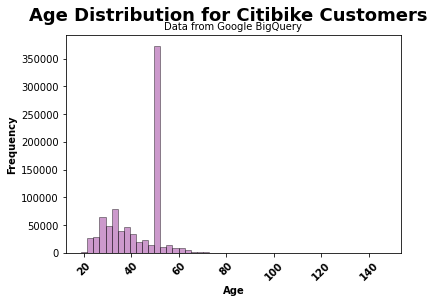

In [318]:
plt.suptitle('Age Distribution for Citibike Customers', weight = 'bold', color = 'black').set_fontsize(18)
plt.title('Data from Google BigQuery', color = 'black').set_fontsize(10)
sns.distplot(all_age_customer_df['age'], kde=False, bins = 50, color = 'purple', hist_kws=dict(edgecolor='black'))
plt.xlabel('Age', weight = 'bold', color = 'black')
plt.ylabel('Frequency', weight = 'bold', color = 'black')
plt.xticks(rotation=45, weight = 'bold', color = 'black')

In [527]:
print('The average age for Citibike customers is:', round(all_age_customer_df['age'].mean()))
print('The median age for Citibike customers is:', round(all_age_customer_df['age'].median()))

The average age for Citibike customers is: 43
The median age for Citibike customers is: 50


### The average age for Citibike customers, 43, is similar to the Citibike subscriber average age. However, the median age increases by nearly a decade from 42 to 50. 

In [529]:
m_cust_age = """ SELECT DATE(starttime) AS trip_date,
                  tripduration / 60 AS trip_in_min, 2021 - birth_year AS age,
                  FROM `bigquery-public-data.new_york_citibike.citibike_trips`
                  WHERE usertype = 'Customer' AND gender = 'male'
                  ORDER BY birth_year DESC 
"""

In [530]:
client = bigquery.Client(project=project_id, credentials=credentials)
m_cust_age_df = client.query(m_cust_age).to_dataframe()
m_cust_age_df

,trip_date,trip_in_min,age
0,2018-05-26,207.283333,19.0
1,2018-04-21,29.583333,19.0
2,2018-05-04,26.066667,19.0
3,2018-04-01,16.400000,19.0
4,2018-05-05,23.133333,19.0
...,...,...,...
303259,2014-06-24,20.366667,NaN
303260,2014-06-27,20.633333,NaN
303261,2013-07-28,13.416667,NaN
303262,2013-07-10,7.116667,NaN


/Applications/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(array([  0.,  20.,  40.,  60.,  80., 100., 120., 140., 160.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

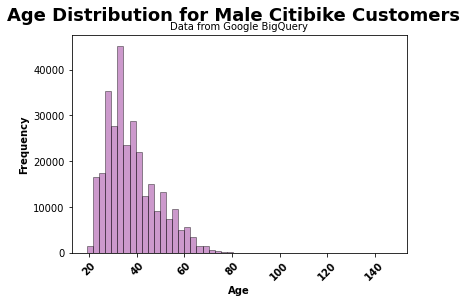

In [534]:
plt.suptitle('Age Distribution for Male Citibike Customers', weight = 'bold', color = 'black').set_fontsize(18)
plt.title('Data from Google BigQuery', color = 'black').set_fontsize(10)
sns.distplot(m_cust_age_df['age'], kde=False, bins = 50, color = 'purple', hist_kws=dict(edgecolor='black'))
plt.xlabel('Age', weight = 'bold', color = 'black')
plt.ylabel('Frequency', weight = 'bold', color = 'black')
plt.xticks(rotation=45, weight = 'bold', color = 'black')

In [537]:
print('The average age for male Citibike customers is:', round(m_cust_age_df['age'].mean()))
print('The median age for male Citibike customers is:', round(m_cust_age_df['age'].median()))

The average age for male Citibike customers is: 38
The median age for male Citibike customers is: 35


### The average and median ages for male Citibike customers are slightly younger than their subscriber counterparts, at 38 and 35, respectively.  

In [532]:
f_cust_age = """ SELECT DATE(starttime) AS trip_date,
                  tripduration / 60 AS trip_in_min, 2021 - birth_year AS age,
                  FROM `bigquery-public-data.new_york_citibike.citibike_trips`
                  WHERE usertype = 'Customer' AND gender = 'female'
                  ORDER BY birth_year DESC 
"""

In [533]:
client = bigquery.Client(project=project_id, credentials=credentials)
f_cust_age_df = client.query(f_cust_age).to_dataframe()
f_cust_age_df

,trip_date,trip_in_min,age
0,2018-03-31,49.516667,19.0
1,2018-02-17,59.416667,19.0
2,2018-04-22,73.516667,19.0
3,2018-04-09,74.366667,19.0
4,2018-05-09,12.633333,19.0
...,...,...,...
187696,2017-04-14,28.983333,121.0
187697,2017-04-14,21.366667,121.0
187698,2017-04-16,14.350000,135.0
187699,2017-04-16,1040.716667,135.0


(array([  0.,  20.,  40.,  60.,  80., 100., 120., 140., 160.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

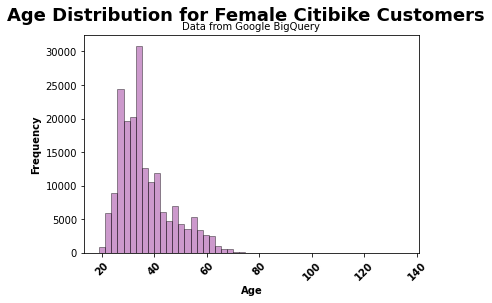

In [536]:
plt.suptitle('Age Distribution for Female Citibike Customers', weight = 'bold', color = 'black').set_fontsize(18)
plt.title('Data from Google BigQuery', color = 'black').set_fontsize(10)
sns.distplot(f_cust_age_df['age'], kde=False, bins = 50, color = 'purple', hist_kws=dict(edgecolor='black'))
plt.xlabel('Age', weight = 'bold', color = 'black')
plt.ylabel('Frequency', weight = 'bold', color = 'black')
plt.xticks(rotation=45, weight = 'bold', color = 'black')

In [538]:
print('The average age for female Citibike customers is:', round(f_cust_age_df['age'].mean()))
print('The median age for female Citibike customers is:', round(f_cust_age_df['age'].median()))

The average age for female Citibike customers is: 36
The median age for female Citibike customers is: 34


### The average and median ages for female Citibike customers is the lowest out of all the queries so far, with a mean age of 36 and a median of just 34 years old. 

In [319]:
eighteen_thirty_five_cust = """ SELECT DATE(starttime) AS trip_date,
                  tripduration / 60 AS trip_in_min, 2021 - birth_year AS age, gender,
                  FROM `bigquery-public-data.new_york_citibike.citibike_trips`
                  WHERE birth_year BETWEEN 1985 AND 2003 AND usertype = 'Customer'
                  ORDER BY birth_year DESC 
"""

In [320]:
client = bigquery.Client(project=project_id, credentials=credentials)
eighteen_thirty_five_cust_df = client.query(eighteen_thirty_five_cust).to_dataframe()
eighteen_thirty_five_cust_df

,trip_date,trip_in_min,age
0,2018-05-28,4.200000,19
1,2018-05-30,8.133333,19
2,2018-05-06,32.616667,19
3,2018-05-06,6.733333,19
4,2018-05-09,12.633333,19
...,...,...,...
288251,2018-04-14,9.400000,36
288252,2018-05-11,8.216667,36
288253,2017-06-11,13.133333,36
288254,2017-06-20,9.050000,36


/Applications/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(array([17.5, 20. , 22.5, 25. , 27.5, 30. , 32.5, 35. , 37.5]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

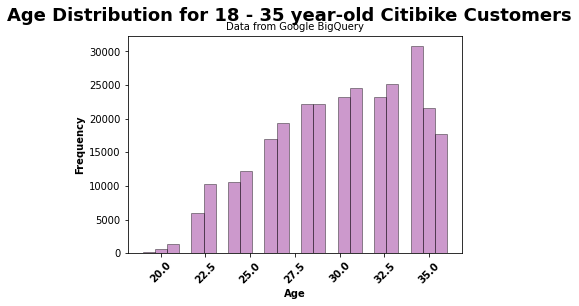

In [321]:
plt.suptitle('Age Distribution for 18 - 35 year-old Citibike Customers', weight = 'bold', color = 'black').set_fontsize(18)
plt.title('Data from Google BigQuery', color = 'black').set_fontsize(10)
sns.distplot(eighteen_thirty_five_cust_df['age'], kde=False, bins = 25, color = 'purple', hist_kws=dict(edgecolor='black'))
plt.xlabel('Age', weight = 'bold', color = 'black')
plt.ylabel('Frequency', weight = 'bold', color = 'black')
plt.xticks(rotation=45, weight = 'bold', color = 'black')

### Even in the coveted 18 - 35 demographic, Citibike customers tend to be renting younger more frequently than Citibike subscribers. 

In [350]:
east_side_sub = """ SELECT DATE(starttime) AS trip_date, tripduration / 60 AS trip_in_min,
                2021 - birth_year AS age, end_station_name AS end_dest
                FROM `bigquery-public-data.new_york_citibike.citibike_trips`
                WHERE end_station_name LIKE 'E_%' AND usertype = 'Subscriber'
                ORDER BY tripduration
                """

In [351]:
client = bigquery.Client(project=project_id, credentials=credentials)
east_side_sub_df = client.query(east_side_sub).to_dataframe()
east_side_sub_df

,trip_date,trip_in_min,age,end_dest
0,2013-11-08,1.000000,65.0,E 6 St & Avenue B
1,2013-07-27,1.000000,56.0,E 19 St & 3 Ave
2,2013-09-02,1.000000,48.0,E 47 St & 2 Ave
3,2015-06-20,1.000000,33.0,E 30 St & Park Ave S
4,2015-04-15,1.000000,33.0,E 25 St & 1 Ave
...,...,...,...,...
9579842,2013-11-14,0.000030,43.0,E 10 St & Avenue A
9579843,2015-08-25,0.000029,44.0,E 6 St & Avenue D
9579844,2016-06-05,0.000029,41.0,E 6 St & Avenue D
9579845,2017-08-06,0.000017,61.0,E 11 St & Broadway


In [388]:
east_side_sub_percent = """ SELECT end_station_name,
                    COUNT(end_station_name) AS end_count,
                    COUNT(end_station_name) * 100.0 / (SELECT COUNT(*) FROM `bigquery-public-data.new_york_citibike.citibike_trips`) AS end_dest_percent
                    FROM `bigquery-public-data.new_york_citibike.citibike_trips`
                    WHERE end_station_name LIKE 'E_%' AND usertype = 'Subscriber'
                    GROUP BY end_station_name
                    ORDER BY end_dest_percent DESC
                    LIMIT 15
                    """ 

In [389]:
client = bigquery.Client(project=project_id, credentials=credentials)
east_side_sub_percent_df = client.query(east_side_sub_percent).to_dataframe()
east_side_sub_percent_df

,end_station_name,end_count,end_dest_percent
0,E 17 St & Broadway,405339,0.687741
1,E 7 St & Avenue A,223783,0.379694
2,E 32 St & Park Ave,217382,0.368833
3,E 47 St & Park Ave,213772,0.362708
4,E 39 St & 2 Ave,203622,0.345487
5,E 16 St & 5 Ave,202790,0.344075
6,E 10 St & Avenue A,201934,0.342623
7,E 12 St & 3 Ave,200465,0.340130
8,E 11 St & 2 Ave,193787,0.328800
9,E 20 St & 2 Ave,188138,0.319215


### A defining characteristic of any New York route is whether or not one's destination is on the east side or west side of New York City. Therefore, the following graphs will examine the most popular destinations by orientation.  

/Applications/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'End Station Name')

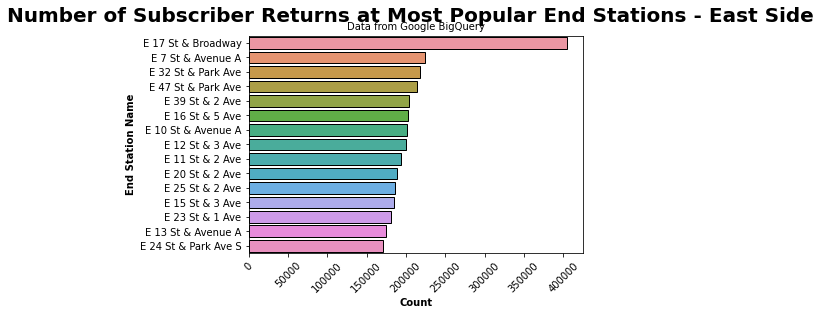

In [564]:
plt.suptitle('Number of Subscriber Returns at Most Popular End Stations - East Side', weight = 'bold', color = 'black').set_fontsize(20)
plt.title('Data from Google BigQuery', color = 'black').set_fontsize(10)
sns.barplot('end_count', 'end_station_name', data = east_side_sub_percent_df, edgecolor = 'black') 
plt.xlabel('Count', weight = 'bold', color = 'black')
plt.xticks(rotation=45)
plt.ylabel('End Station Name', weight = 'bold', color = 'black')

### The most popular east side destinations for subscribers to return bikes to were concentrated between lower and mid-town Manhattan, with the East 17th & Broadway station being the most popular return site. 

In [396]:
west_side_sub_percent = """ SELECT end_station_name,
                    COUNT(end_station_name) AS end_count,
                    COUNT(end_station_name) * 100.0 / (SELECT COUNT(*) FROM `bigquery-public-data.new_york_citibike.citibike_trips`) AS end_dest_percent
                    FROM `bigquery-public-data.new_york_citibike.citibike_trips`
                    WHERE end_station_name LIKE 'W_%' AND usertype = 'Subscriber'
                    GROUP BY end_station_name
                    ORDER BY end_dest_percent DESC
                    LIMIT 15
                    """ 

In [397]:
client = bigquery.Client(project=project_id, credentials=credentials)
west_side_sub_percent_df = client.query(west_side_sub_percent).to_dataframe()
west_side_sub_percent_df

,end_station_name,end_count,end_dest_percent
0,W 21 St & 6 Ave,390647,0.662813
1,West St & Chambers St,303744,0.515364
2,W 41 St & 8 Ave,300633,0.510086
3,W 20 St & 11 Ave,274140,0.465135
4,W 18 St & 6 Ave,268483,0.455537
5,W 33 St & 7 Ave,257193,0.436381
6,W 38 St & 8 Ave,255009,0.432675
7,W 31 St & 7 Ave,252902,0.429100
8,W 24 St & 7 Ave,231719,0.393159
9,W 22 St & 10 Ave,226164,0.383734


/Applications/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'End Station Name')

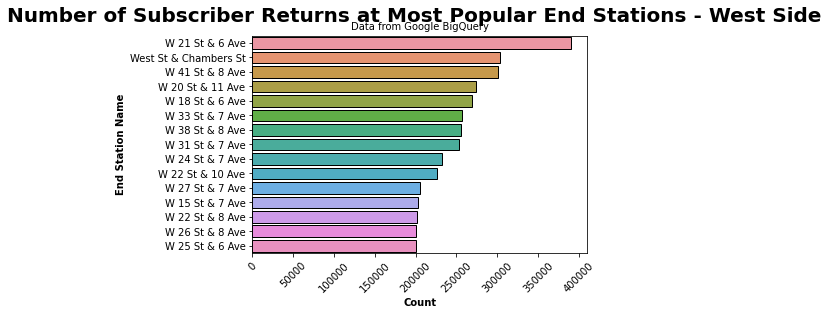

In [548]:
plt.suptitle('Number of Subscriber Returns at Most Popular End Stations - West Side', weight = 'bold', color = 'black').set_fontsize(20)
plt.title('Data from Google BigQuery', color = 'black').set_fontsize(10)
sns.barplot('end_count', 'end_station_name', data = west_side_sub_percent_df, edgecolor = 'black') 
plt.xlabel('Count', weight = 'bold', color = 'black')
plt.xticks(rotation=45, color = 'black')
plt.yticks(color = 'black')
plt.ylabel('End Station Name', weight = 'bold', color = 'black')

### West side returns also seemed to be concentrated largely in lower Manhattan, with the furthest north station being W 41st street & 8th avenue. The most popular return station on the west side was West 21st & 6th avenue. 6th avenue is one of the most popular streets for tourism and transit in the city. 

In [413]:
start_dest_sub_east = """ SELECT start_station_name, COUNT(start_station_name) AS start_count,
                     COUNT(start_station_name) * 100 / (SELECT COUNT(*) FROM `bigquery-public-data.new_york_citibike.citibike_trips`) AS start_dest_percent
                     FROM `bigquery-public-data.new_york_citibike.citibike_trips`
                     WHERE start_station_name LIKE 'E_%' AND usertype = 'Subscriber'
                     GROUP BY start_station_name
                     ORDER BY start_dest_percent DESC
                     LIMIT 15
                    """ 

In [414]:
client = bigquery.Client(project=project_id, credentials=credentials)
start_dest_sub_east_df = client.query(start_dest_sub_east).to_dataframe()
start_dest_sub_east_df

,start_station_name,start_count,start_dest_percent
0,E 17 St & Broadway,385604,0.654257
1,E 32 St & Park Ave,221603,0.375995
2,E 47 St & Park Ave,215869,0.366266
3,E 7 St & Avenue A,212136,0.359933
4,E 39 St & 2 Ave,206865,0.350989
5,E 16 St & 5 Ave,200050,0.339426
6,E 10 St & Avenue A,197362,0.334865
7,E 12 St & 3 Ave,197154,0.334512
8,E 11 St & 2 Ave,191176,0.324370
9,E 25 St & 2 Ave,188511,0.319848


/Applications/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Start Station Name')

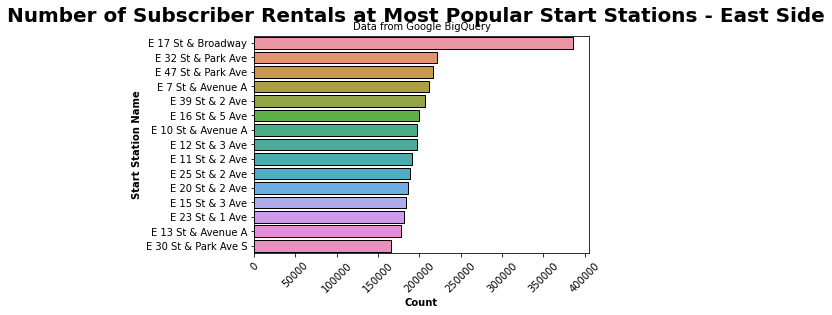

In [549]:
plt.suptitle('Number of Subscriber Rentals at Most Popular Start Stations - East Side', weight = 'bold', color = 'black').set_fontsize(20)
plt.title('Data from Google BigQuery', color = 'black').set_fontsize(10)
sns.barplot('start_count', 'start_station_name', data = start_dest_sub_east_df, edgecolor = 'black') 
plt.xlabel('Count', weight = 'bold', color = 'black')
plt.xticks(rotation=45, color = 'black')
plt.yticks(color = 'black')
plt.ylabel('Start Station Name', weight = 'bold', color = 'black')

### Some of the most popular starting stations for Citibike subscribers were concentrated on the far east side, since Park Ave and 1st, 2nd and 3rd avenues are as far east as New Yorkers can go before hitting the East River. The most popular start station was the same as the ending destination: East 17th St & Broadway. 

In [417]:
start_dest_sub_west = """ SELECT start_station_name, COUNT(start_station_name) AS start_count,
                     COUNT(start_station_name) * 100 / (SELECT COUNT(*) FROM `bigquery-public-data.new_york_citibike.citibike_trips`) AS start_dest_percent
                     FROM `bigquery-public-data.new_york_citibike.citibike_trips`
                     WHERE start_station_name LIKE 'W_%' AND usertype = 'Subscriber'
                     GROUP BY start_station_name
                     ORDER BY start_dest_percent DESC
                     LIMIT 15
                    """ 

In [418]:
client = bigquery.Client(project=project_id, credentials=credentials)
start_dest_sub_west_df = client.query(start_dest_sub_west).to_dataframe()
start_dest_sub_west_df

,start_station_name,start_count,start_dest_percent
0,W 21 St & 6 Ave,385573,0.654204
1,West St & Chambers St,299307,0.507836
2,W 41 St & 8 Ave,291777,0.495060
3,W 20 St & 11 Ave,264623,0.448988
4,W 18 St & 6 Ave,260921,0.442706
5,W 38 St & 8 Ave,257424,0.436773
6,W 31 St & 7 Ave,256964,0.435992
7,W 24 St & 7 Ave,230214,0.390606
8,W 33 St & 7 Ave,229737,0.389796
9,W 22 St & 10 Ave,223933,0.379949


/Applications/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Start Station Name')

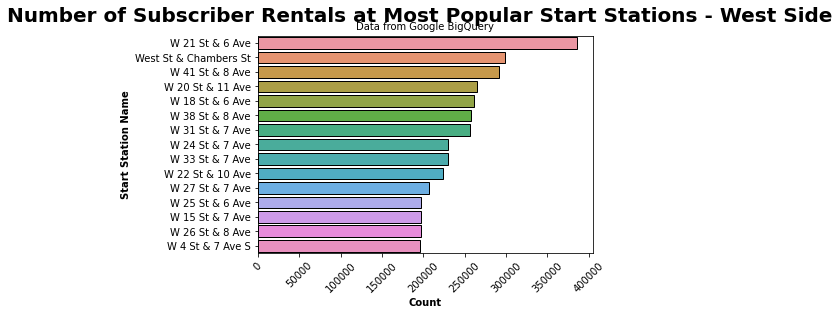

In [550]:
plt.suptitle('Number of Subscriber Rentals at Most Popular Start Stations - West Side', weight = 'bold', color = 'black').set_fontsize(20)
plt.title('Data from Google BigQuery', color = 'black').set_fontsize(10)
sns.barplot('start_count', 'start_station_name', data = start_dest_sub_west_df, edgecolor = 'black') 
plt.xlabel('Count', weight = 'bold', color = 'black')
plt.xticks(rotation=45, color = 'black')
plt.yticks(color = 'black')
plt.ylabel('Start Station Name', weight = 'bold', color = 'black')

In [427]:
start_dest_sub_west_cust = """ SELECT start_station_name, COUNT(start_station_name) AS start_count,
                     COUNT(start_station_name) * 100 / (SELECT COUNT(*) FROM `bigquery-public-data.new_york_citibike.citibike_trips`) AS start_dest_percent
                     FROM `bigquery-public-data.new_york_citibike.citibike_trips`
                     WHERE start_station_name LIKE 'W_%' AND usertype = 'Customer'
                     GROUP BY start_station_name
                     ORDER BY start_dest_percent DESC
                     LIMIT 15
                    """ 

In [428]:
client = bigquery.Client(project=project_id, credentials=credentials)
start_dest_sub_west_cust_df = client.query(start_dest_sub_west_cust).to_dataframe()
start_dest_sub_west_cust_df

,start_station_name,start_count,start_dest_percent
0,West St & Chambers St,84809,0.143896
1,Washington St & Gansevoort St,45695,0.077531
2,W 20 St & 11 Ave,43959,0.074586
3,W 14 St & The High Line,32983,0.055962
4,W 34 St & 11 Ave,31548,0.053528
5,West Thames St,27412,0.046510
6,W 16 St & The High Line,25532,0.043320
7,W 4 St & 7 Ave S,23915,0.040577
8,W 22 St & 10 Ave,23726,0.040256
9,W Broadway & Spring St,23614,0.040066


/Applications/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Start Station Name')

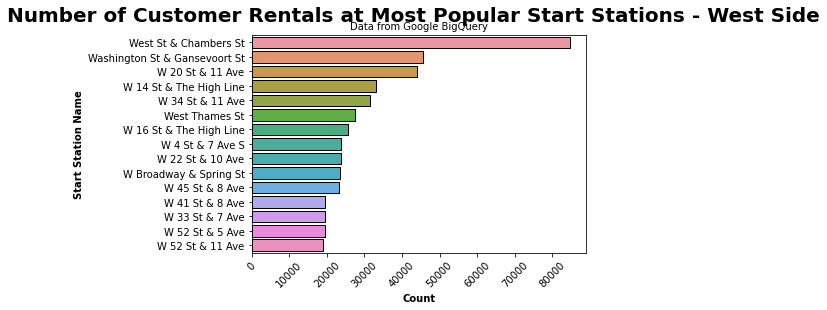

In [551]:
plt.suptitle('Number of Customer Rentals at Most Popular Start Stations - West Side', weight = 'bold', color = 'black').set_fontsize(20)
plt.title('Data from Google BigQuery', color = 'black').set_fontsize(10)
sns.barplot('start_count', 'start_station_name', data = start_dest_sub_west_cust_df, edgecolor = 'black') 
plt.xlabel('Count', weight = 'bold', color = 'black')
plt.xticks(rotation=45, color = 'black')
plt.yticks(color = 'black')
plt.ylabel('Start Station Name', weight = 'bold', color = 'black')

### While subscriber rentals were relatively distributed among fifteen stations, customer rentals reveal a stark gap between the leading station and secondary station. In the case of starting rentals, the difference between West St and Washington Street is double (40,000 vs. 80,000). 

In [433]:
end_dest_west_cust = """ SELECT end_station_name, COUNT(end_station_name) AS end_count,
                     COUNT(end_station_name) * 100 / (SELECT COUNT(*) FROM `bigquery-public-data.new_york_citibike.citibike_trips`) AS end_dest_percent
                     FROM `bigquery-public-data.new_york_citibike.citibike_trips`
                     WHERE end_station_name LIKE 'W_%' AND usertype = 'Customer'
                     GROUP BY end_station_name
                     ORDER BY end_dest_percent DESC
                     LIMIT 15
                    """ 

In [434]:
client = bigquery.Client(project=project_id, credentials=credentials)
end_dest_west_cust_df = client.query(end_dest_west_cust).to_dataframe()
end_dest_west_cust_df

,end_station_name,end_count,end_dest_percent
0,West St & Chambers St,95289,0.161677
1,W 20 St & 11 Ave,49507,0.083999
2,Washington St & Gansevoort St,45186,0.076667
3,W 14 St & The High Line,39786,0.067505
4,W 34 St & 11 Ave,29063,0.049311
5,W 45 St & 8 Ave,26465,0.044903
6,W 22 St & 10 Ave,26162,0.044389
7,W 16 St & The High Line,25773,0.043729
8,W Broadway & Spring St,25218,0.042788
9,West Thames St,25058,0.042516


Text(0, 0.5, 'Start Station Name')

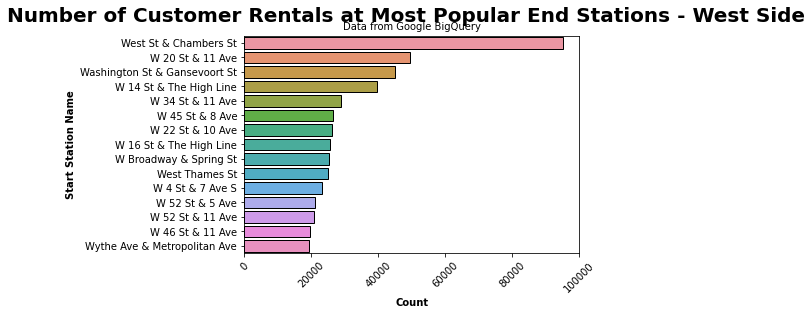

In [553]:
plt.suptitle('Number of Customer Rentals at Most Popular End Stations - West Side', weight = 'bold', color = 'black').set_fontsize(20)
plt.title('Data from Google BigQuery', color = 'black').set_fontsize(10)
sns.barplot('end_count', 'end_station_name', data = end_dest_west_cust_df, edgecolor = 'black') 
plt.xlabel('Count', weight = 'bold', color = 'black')
plt.xticks(rotation=45, color = 'black')
plt.yticks(color = 'black')
plt.ylabel('Start Station Name', weight = 'bold', color = 'black')

In [437]:
start_dest_east_cust = """ SELECT start_station_name, COUNT(start_station_name) AS start_count,
                     COUNT(start_station_name) * 100 / (SELECT COUNT(*) FROM `bigquery-public-data.new_york_citibike.citibike_trips`) AS start_dest_percent
                     FROM `bigquery-public-data.new_york_citibike.citibike_trips`
                     WHERE start_station_name LIKE 'E_%' AND usertype = 'Customer'
                     GROUP BY start_station_name
                     ORDER BY start_dest_percent DESC
                     LIMIT 15
                    """ 

In [438]:
client = bigquery.Client(project=project_id, credentials=credentials)
start_dest_east_cust_df = client.query(start_dest_east_cust).to_dataframe()
start_dest_east_cust_df

,start_station_name,start_count,start_dest_percent
0,E 17 St & Broadway,37730,0.064017
1,E 33 St & 5 Ave,18236,0.030941
2,E 11 St & 2 Ave,17117,0.029043
3,E 10 St & Avenue A,15599,0.026467
4,E 40 St & 5 Ave,15519,0.026331
5,E 7 St & Avenue A,14546,0.024680
6,E 16 St & 5 Ave,14032,0.023808
7,E 58 St & 3 Ave,13642,0.023146
8,E 39 St & 2 Ave,13629,0.023124
9,E 30 St & Park Ave S,13233,0.022453


Text(0, 0.5, 'Start Station Name')

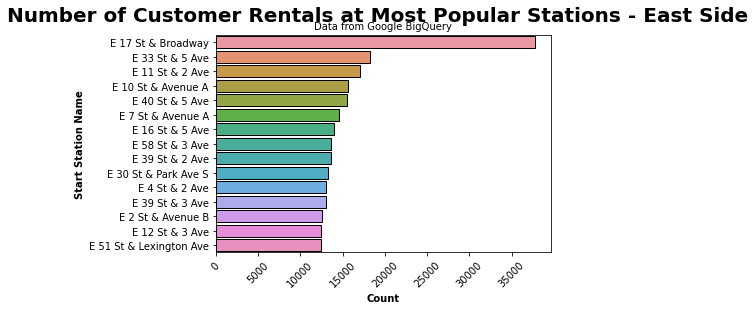

In [555]:
plt.suptitle('Number of Customer Rentals at Most Popular Stations - East Side', weight = 'bold', color = 'black').set_fontsize(20)
plt.title('Data from Google BigQuery', color = 'black').set_fontsize(10)
sns.barplot('start_count', 'start_station_name', data = start_dest_east_cust_df, edgecolor = 'black') 
plt.xlabel('Count', weight = 'bold', color = 'black')
plt.xticks(rotation=45, color = 'black')
plt.yticks(color = 'black')
plt.ylabel('Start Station Name', weight = 'bold', color = 'black')

### Predictably, the gap between customer rentals and subscriber rentals persists even when dividing the city into its eastern  and western halves. According to the data, subscribers at both the most popular east and west side stations rented at a rate of 3 times that of customers renting at that same station. 

### Although Citibike has a significant subscriber presence in New York City, 20% of renters are still only customers, paying a one-time rate instead of a monthly fee. These one-time customers tend to be older, with median and average ages in middle-age range, suggesting that they may be relying on bikes as a form of entertainment while other younger adults subscribe to have a means of consistent transportation. 

### In addition to seeking to convert customers to regular subscribers, Citibike must also offer incentives to new subscribers to bridge the significant gap between customer rentals at both its east and west side starting andending stations. 